In [1]:
%matplotlib inline
import numpy as np
import pylab as pl
import seaborn as sns

/usr/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Résolution d'équations différentielles par méthode pseudo-spectrale
## Projection sur polynomes de Tchebychev

Les méthodes pseudo-spectrales sont des méthodes numériques utilisées pour la résolution des équations différentielles partielles. Elles sont proches des méthodes spectrales, mais sont appliqué sur des noeuds de calculs (appelés points de collocations), permettant l'évaluation des dérivées partielles sur un maillage du domaine. Cela mène à des calculs considérablements accélérés pour peu que l'on choisisse des algorithmes adaptés.

En bref, il s'agira d'approcher notre grandeur par une combinaison linéaire de fonctions connus (série) pondérés de façon à s'ajuster à la fonction d'origine. Un cas "classique" est l'utilisation des séries de Fourrier pour approcher un signal périodique.

Le code suivant fait l'approximation d'une fonction carré par une série de Fourrier dont seule les n premières harmoniques ont été conservées.

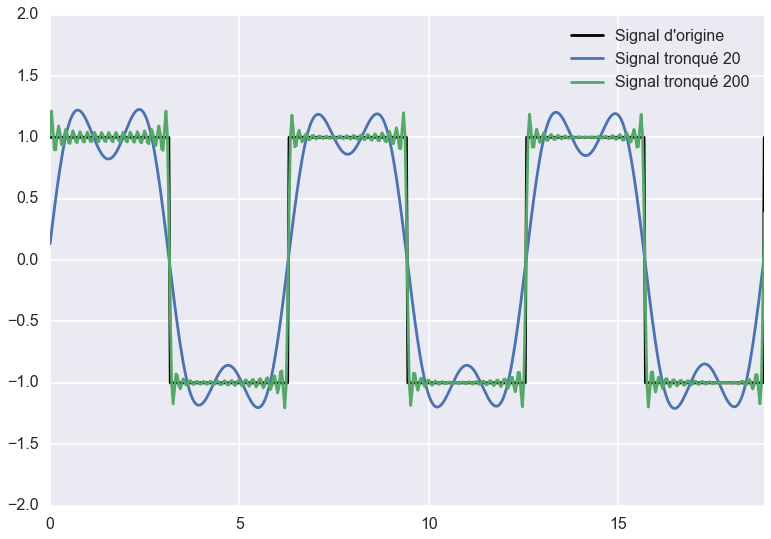

In [2]:
from scipy.signal import sawtooth, square
from scipy.fftpack import rfft, irfft
sns.set_context('poster')

x = np.linspace(0, 3*np.pi*2., 500)
y = square(x)
y_fourrier200 = rfft(y)
y_fourrier20 = rfft(y)
y_fourrier200[200:] = 0
y_fourrier20[20:] = 0
y_real20 = irfft(y_fourrier20)
y_real200 = irfft(y_fourrier200)

pl.plot(x, y, color='black')
pl.plot(x, y_real20)
pl.plot(x, y_real200)
pl.xlim(0, 3*np.pi*2.)
pl.ylim(-2, 2)
pl.legend(["Signal d'origine", "Signal tronqué 20", "Signal tronqué 200"], loc='best')
pl.show()

Les séries de fourrier ne sont appliquables qu'aux signaux périodiques, d'où leur succès dans le traitement du signal. Il est nécessaire d'utiliser d'autres séries pour approcher des fonctions non-périodiques. Les fonctions polynomiales sont de bons candidats pour interpoler des fonctions non périodiques : les polynomes de Legendre, de Tchebychev, de Hermites sont des fonctions polynomiales capables d'approcher correctement les fonctions qui ne sont pas trop fortement non-linéaires, à condition de choisir correctement les points d'interpolations.

Avec des polynomes de Tchebychev :

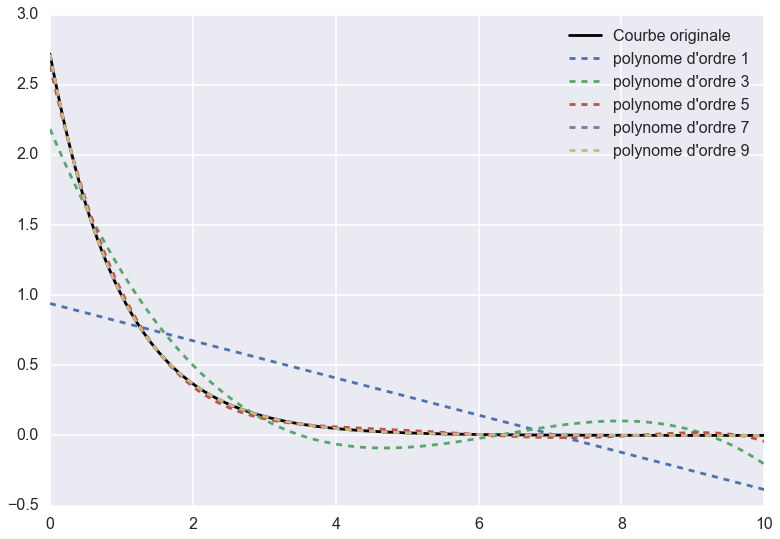

In [3]:
from numpy.polynomial import chebyshev as C

x = np.linspace(0, 10, 200)
y = np.exp(1 - x)
pl.plot(x, y, color='black')
legend = ['Courbe originale']
for n in range(1, 10, 2):
    coeffs_tcheby = C.chebfit(x, y, n)
    y_tch = C.chebval(x, coeffs_tcheby)
    pl.plot(x, y_tch, linestyle='--')
    legend.append("polynome d'ordre %i" % n)
pl.legend(legend)
pl.show()

L'interet majeur de l'utilisation de tels polynomes est que leur dérivées et primitives sont calculable directement par récursivité.

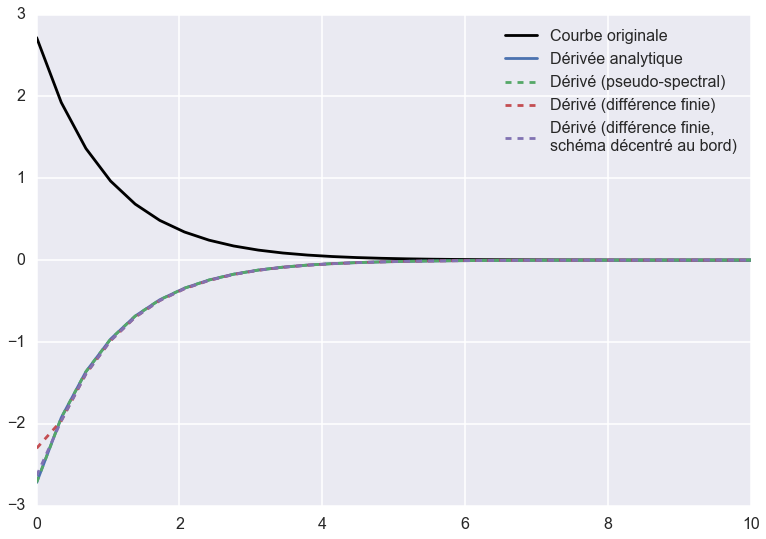

In [4]:
x = np.linspace(0, 10, 30)
y = np.exp(1 - x)
pl.plot(x, y, color='black')
pl.plot(x, -np.exp(1-x))
legend = ['Courbe originale', 'Dérivée analytique']
coeffs_tcheby = C.chebfit(x, y, 10)
coeffs_tcheby_diff = C.chebder(coeffs_tcheby)
y_tch = C.chebval(x, coeffs_tcheby_diff)
pl.plot(x, y_tch, linestyle='--')
legend.append('Dérivé (pseudo-spectral)')
pl.plot(x, np.gradient(y)/np.gradient(x), linestyle='--')
legend.append('Dérivé (différence finie)')
pl.plot(x, np.gradient(y, edge_order=2)/np.gradient(x, edge_order=2), linestyle='--')
legend.append('Dérivé (différence finie,\nschéma décentré au bord)')
pl.legend(legend)
pl.show()

On observe en particulier que le traitement des conditions de bord est plus "propre" que lors de l'utilisation d'un schéma différence fini. La courbe est confondue avec la de la dérivée exacte. Il est nécessaire d'utiliser un schéma différence fini mixte (centré pour les valeur milieu, décentré sur les bords) ou de rajouter des points factices au bord pour éviter ces erreurs, ce qui peut rendre peu évident la mise en place de conditions de bord.

## Application : l'équation de la chaleur

Imaginons une barre métalique traversant un mur parfaitement isolé. D'un coté du mur, une température $T_{ext} = 0$°C, de l'autre, $T_{ext} = 20$°C.
Jusque là, la résolution analytique est possible, et même facile.

Pour compliquer la situation, ajoutant un courant électrique périodique échauffant notre barre métalique, ajoutant un terme de chaleur $r cos(f t)$.

Le calcul se complique, mais reste accessible. En utilisant une méthode pseudo-spectrale, nous arrivons très vite au résultats escompté, avec une précision très correct même avec des polynomes de faible degrès et un nombre de points de collocation réduits : les figures suivantes représentent la température le long de cette barre au cours du temps. Les calculs ont été effectués pour un nombre croissant de points de collocation et de polynomes.

/usr/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


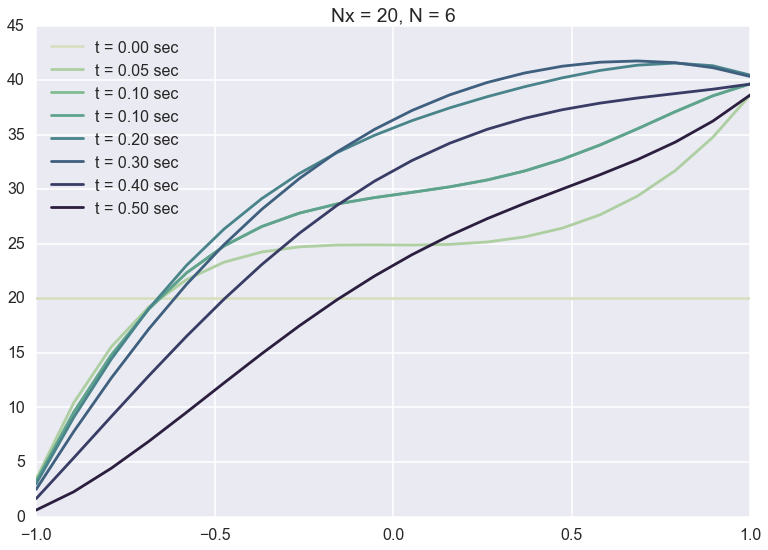

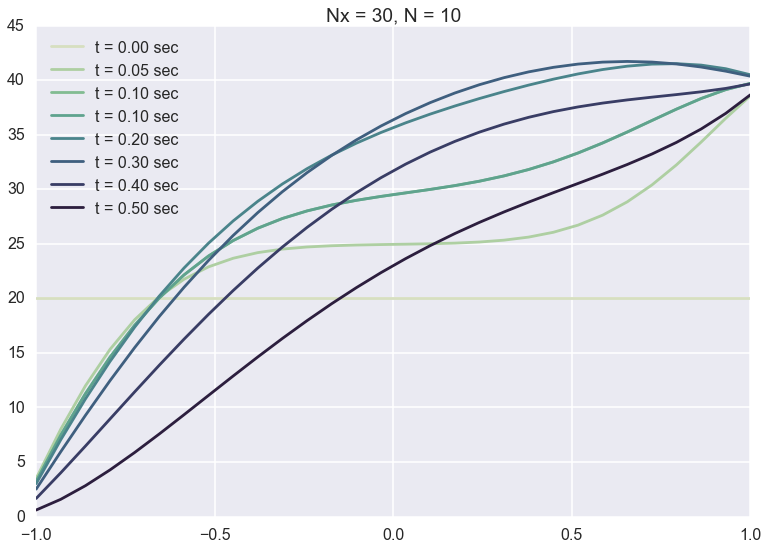

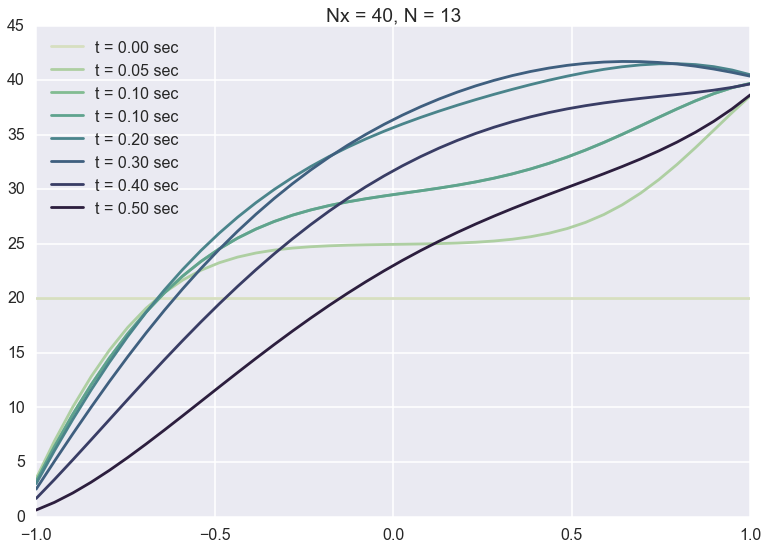

In [5]:
from scipy.integrate import odeint
sns.set_palette(sns.cubehelix_palette(8, start=.5, rot=-.75))
#sns.palplot()

def fourrier(T, t, x, k, r, rho, cp, h, T_ext_l, T_ext_r, N):
    """
    The heat equation : we return the rhs.
    This function will be used via the odeint algorithm.
    """
    
    # We use a dirichlet DBC : fixed value of T(x=0)
    # T[-1] = T_ext_r + 10 * np.cos(t)
    # We adjust a N basis of Tchebychev polynomial according the T values (taking account the BDC)
    r = r * np.cos(5*t)
    cheb_coeffs = C.chebfit(x, T, N)
    # We apply the derivative on the Tchebychev polynomial
    chebdiff = C.chebder(cheb_coeffs, 1)
    # Go back to the real space : we now have the first order derivative
    dxT = C.chebval(x, chebdiff)
    # This time, a Cauchy BDC is used (convective-like BDC)
    dxT[0] =  h * (T[0] - T_ext_l) # + 10 * np.cos(t)))
    dxT[-1] = h * (T_ext_r - T[-1]) # * np.cos(t) - T[-1])
    # We do the same thing for the 2nd derivative
    cheb_coeffs = C.chebfit(x, dxT, N)
    chebdiff = C.chebder(cheb_coeffs, 1)
    dxxT = C.chebval(x, chebdiff)
    
    # We have all we need, ie the 2nd derivative with the boundary conditions that we want.
    
    dtT = (k*(dxxT) + r) / (rho * cp)
    
    return dtT
  



for Nx in range(20, 50, 10):
    x, dx = np.linspace(-1, 1, Nx, retstep=True)
    T0 = np.zeros(x.shape) + 20
    k = 1
    r = 100
    cp = 1.
    rho = 1
    h = 20
    T_ext_l = 0
    T_ext_r = 20
    
    N = int(Nx / 3)

    t = np.concatenate([np.linspace(0, .1, 3), np.linspace(.1, .5, 5)])

    solutions = odeint(fourrier, T0, t, args=(x, k, r, rho, cp, h, T_ext_l, T_ext_r, N))

    for sol, t_ in zip(solutions, t):
        pl.plot(x, sol, label='t = %.2f sec'%(t_))
    pl.title('Nx = %i, N = %i'%(Nx, N))
    pl.legend(loc='best')
    pl.show()

Il est possible de travailler en deux dimensions également : ainsi pour la fonction $f(x, y) = cos(x) sin(y) cos(x+y) sin(x*y)$, nous avons tracé les dérivées partielles $\frac{\partial f}{\partial x}$ et $\frac{\partial f}{\partial y}$ calculées de façon analytique et leur valeur calculées numériquement via les polynomes de Tchebychev. Il est interessant de noter que dans ce cas, il est nécessaire de prendre un nombre important de polynomes, la fonction de base étant fortement non-linéaire.

Degré du polynome : 2


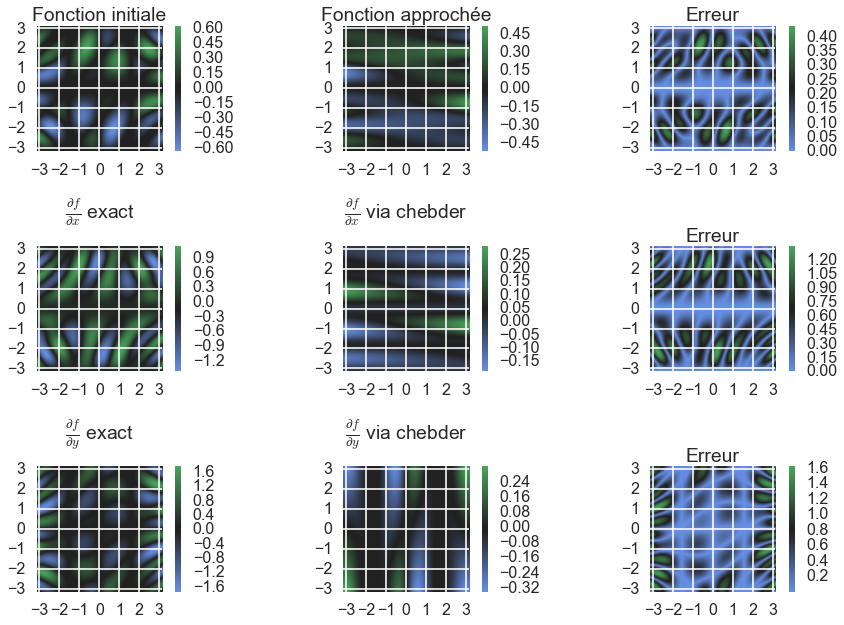

Degré du polynome : 7


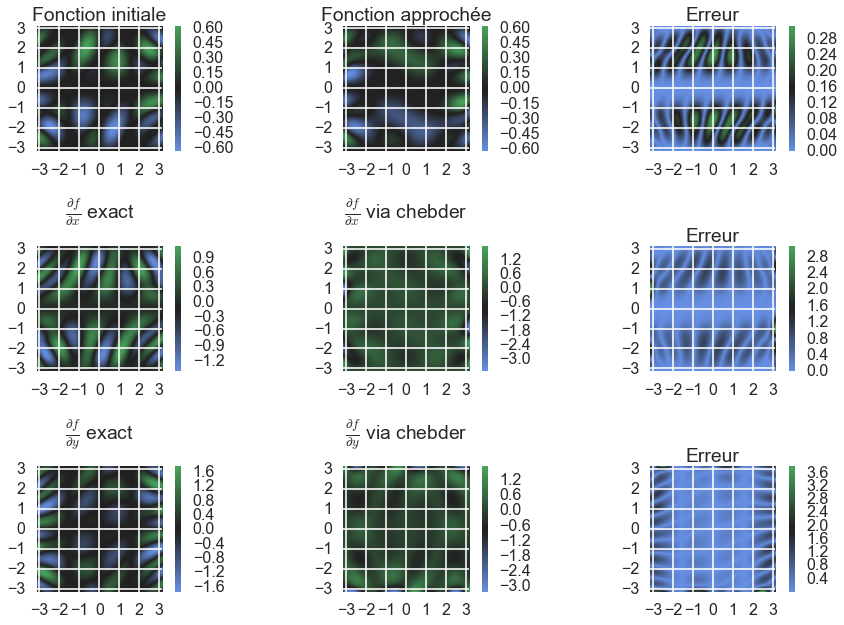

Degré du polynome : 12


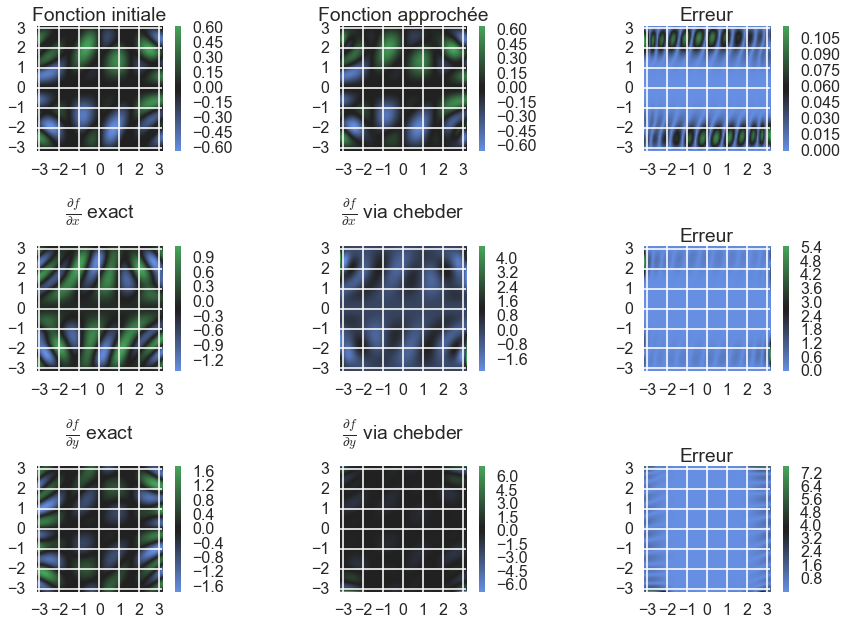

Degré du polynome : 17


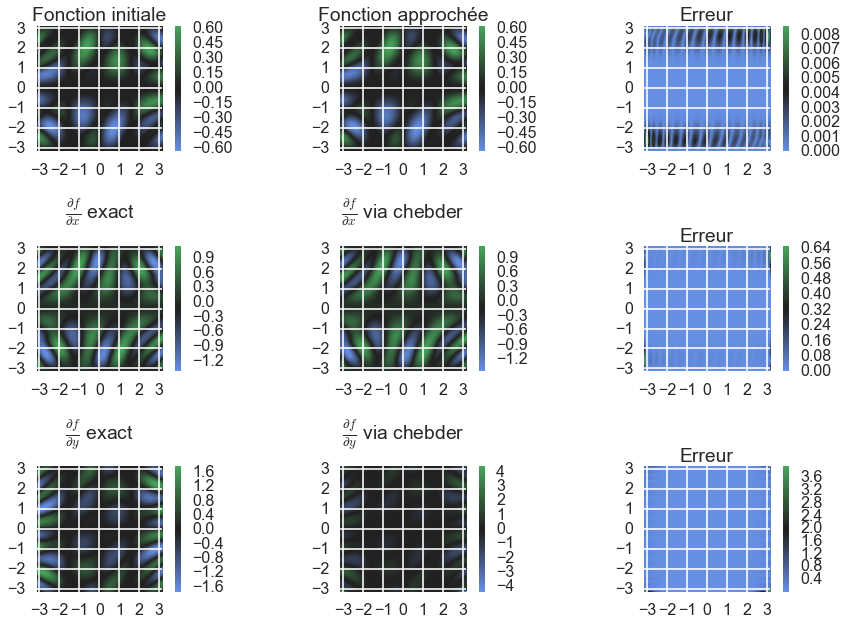

Degré du polynome : 22


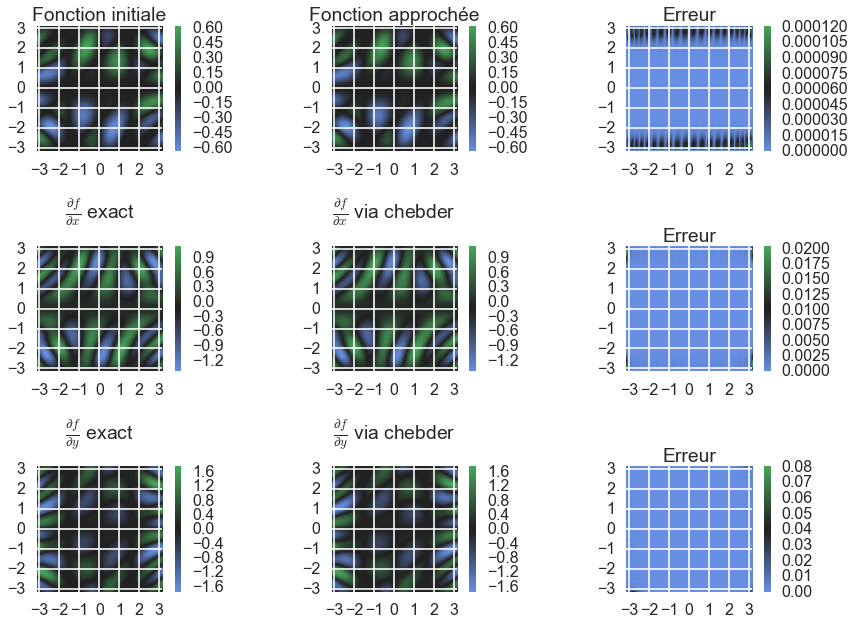

In [115]:
from numpy import cos, sin
cmap = sns.diverging_palette(255, 133, l=60, n=7, center="dark", as_cmap=True)
plotconf = {'cmap': cmap, 'extent': [x_.min(), x_.max(), y_.min(), y_.max()]}


for N in range(2, 25, 5):
    print("Degré du polynome : %i" % N)
    x_ = y_ = np.linspace(-np.pi, np.pi, 100)
    x, y = np.meshgrid(x_, y_)
    f = np.cos(x) * np.sin(y) * np.cos(x+y) * np.sin(x*y)

    pl.subplot(331)
    pl.title('Fonction initiale')
    pl.imshow(f, **plotconf)
    pl.colorbar()
    pl.subplot(332)
    xfit = C.chebfit(x_, f.T, N)
    f_cheb = C.chebval(x_, xfit)
    pl.imshow(f_cheb, **plotconf)
    pl.title('Fonction approchée')
    pl.colorbar()
    pl.subplot(333)
    pl.title('Erreur')
    pl.imshow(np.abs(f - f_cheb), **plotconf)
    pl.colorbar()
    pl.subplot(334)
    dxf_exacte = (y*sin(y)*cos(x)*cos(x*y)*cos(x + y) -
                  sin(x)*sin(y)*sin(x*y)*cos(x + y) -
                  sin(y)*sin(x*y)*sin(x + y)*cos(x))
    pl.imshow(dxf_exacte,
              **plotconf)
    pl.title('$\\frac{\\partial f}{\\partial x}$ exact\n')
    pl.colorbar()
    pl.subplot(335)
    xfit = C.chebfit(x_, f.T, N)
    xfit = C.chebder(xfit)
    dxf = C.chebval(x_, xfit)
    pl.imshow(dxf, **plotconf)
    pl.title('$\\frac{\\partial f}{\\partial x}$ via chebder\n')
    pl.colorbar()
    pl.subplot(336)
    pl.title('Erreur')
    pl.imshow(np.abs(dxf_exacte - dxf), **plotconf)
    pl.colorbar()
    pl.subplot(337)
    dyf_exacte = (x*sin(y)*cos(x)*cos(x*y)*cos(x + y) -
                  sin(y)*sin(x*y)*sin(x + y)*cos(x) +
                  sin(x*y)*cos(x)*cos(y)*cos(x + y))
    pl.imshow(dyf_exacte,
              **plotconf)
    pl.title('$\\frac{\\partial f}{\\partial y}$ exact\n')
    pl.colorbar()
    pl.subplot(338)
    yfit = C.chebfit(y_, f, N)
    yfit = C.chebder(yfit)
    dyf = C.chebval(y_, yfit).T
    pl.imshow(dyf, **plotconf)
    pl.title('$\\frac{\\partial f}{\\partial y}$ via chebder\n')
    pl.colorbar()
    pl.subplot(339)
    pl.title('Erreur')
    pl.imshow(np.abs(dyf_exacte - dyf), **plotconf)
    pl.colorbar()
    pl.tight_layout()
    pl.show()

/usr/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


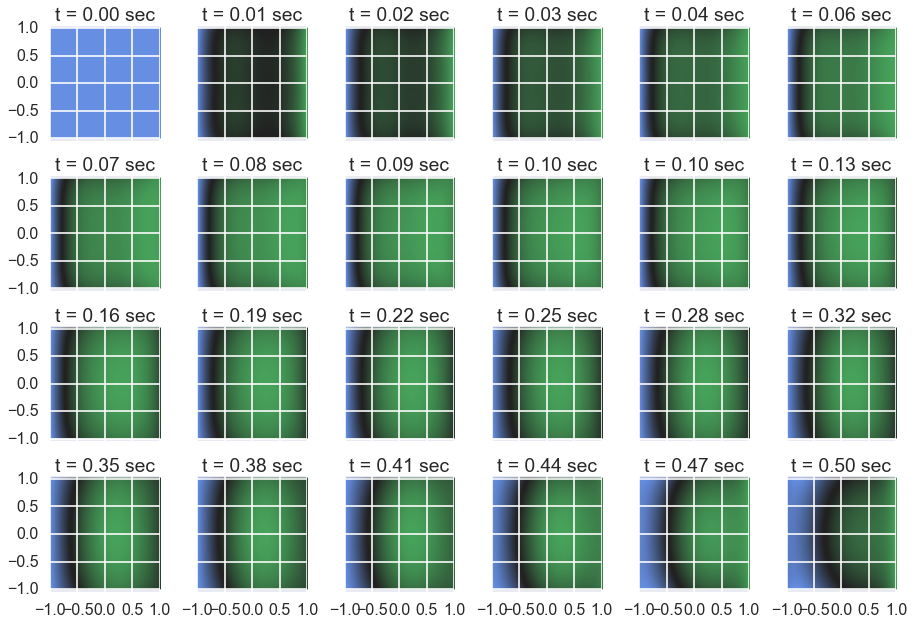

In [107]:
from scipy.integrate import odeint
sns.set_palette(sns.cubehelix_palette(8, start=.5, rot=-.75))
#sns.palplot()

def fourrier(T, t, x, y, k, r, rho, cp, h, T_ext_l, T_ext_r, N):
    """
    The heat equation : we return the rhs.
    This function will be used via the odeint algorithm.
    """
    
    # We use a dirichlet DBC : fixed value of T(x=0)
    # T[-1] = T_ext_r + 10 * np.cos(t)
    # We adjust a N basis of Tchebychev polynomial according the T values (taking account the BDC)
    r = r * np.cos(5*t)
    T = T.reshape(x.shape[0], y.shape[0])
    
    cheb_coeffs_x = C.chebfit(x, T.T, N)
    cheb_coeffs_y = C.chebfit(y, T, N)
    # We apply the derivative on the Tchebychev polynomia
    # Go back to the real space : we now have the first order derivative
    dxT = C.chebval(x, C.chebder(cheb_coeffs_x, 1))
    dyT = C.chebval(y, C.chebder(cheb_coeffs_y, 1)).T
    # This time, a Cauchy BDC is used (convective-like BDC)
    dxT[:, 0] =  h * (T[:, 0] - T_ext_l) # + 10 * np.cos(t)))
    dxT[:, -1] =  -h * (T[:, -1] - T_ext_r) # + 10 * np.cos(t)))
    dyT[0,:] = 20
    dyT[-1,:] = -20
    # We do the same thing for the 2nd derivative
    cheb_coeffs_x = C.chebfit(x, dxT.T, N)
    chebdiff_x = C.chebder(cheb_coeffs_x, 1)
    dxxT = C.chebval(x, chebdiff_x)
    
    cheb_coeffs_y = C.chebfit(y, dyT, N)
    chebdiff_y = C.chebder(cheb_coeffs_y, 1)
    dyyT = C.chebval(x, chebdiff_y).T
    
    # We have all we need, ie the 2nd derivative with the boundary conditions that we want.
    
    dtT = (k*(dxxT + dyyT) + r) / (rho * cp)
    
    return dtT.reshape(x.shape[0]*y.shape[0])
  


Nx = 50
Ny = 50
x, dx = np.linspace(-1, 1, Nx, retstep=True)
y, dy = np.linspace(-1, 1, Ny, retstep=True)
x_, y_ = np.meshgrid(x, y)
T0 = (np.zeros(x_.shape) + 20).reshape(x.shape[0]*y.shape[0])
k = 1
r = 300
cp = 1.
rho = 1
h = 20
T_ext_l = 0
T_ext_r = 40

N = 5

plotconf = {'cmap': cmap, 'extent': [x.min(), x.max(), y.min(), y.max()]}

t = np.concatenate([np.linspace(0, .1, 10), np.linspace(.1, .5, 14)])

solutions = odeint(fourrier, T0, t, args=(x, y, k, r, rho, cp, h, T_ext_l, T_ext_r, N))

fig, axs = pl.subplots(4, 6, sharex='all', sharey='all')
axs_flat = [item for sublist in axs for item in sublist]
for i, (sol, t_) in enumerate(zip(solutions, t)):
    ax = axs_flat[i]
    ax.imshow(sol.reshape(x.shape[0], y.shape[0]), **plotconf)
    ax.set_title('t = %.2f sec'%(t_))
pl.tight_layout()
pl.show()